In [1]:
import torch
from torch import nn

torch.__version__

'2.5.1+cu121'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Get the data
In this tutorial we use subsample of Food101 dataset.<br>
We will load it in format of folders, where images are labeled by the folder they are in

In [3]:
import requests
import zipfile
from pathlib import Path


data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"  # just as in tutorial

if image_path.is_dir():
  print("Directory already exists")
else:
  print(f"Creating {image_path}")
  image_path.mkdir(parents=True, exist_ok=True)

  # load data to zip archive
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading data....")
    f.write(request.content)

  # Unzip data from archive
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping data...")
    zip_ref.extractall(image_path)

Creating data/pizza_steak_sushi
Unzipping data...


## Data Exploration

In [4]:
import os


def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak


In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

**Let's visualize a random image**

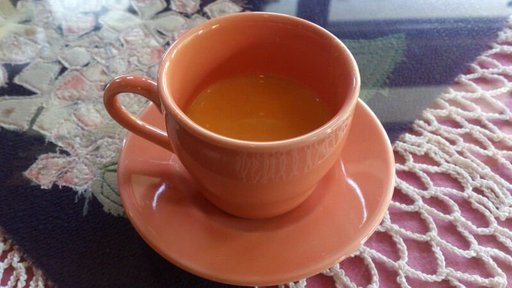

In [6]:
import random
from PIL import Image

random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))  # all .jpg files
random_image_path = random.choice(image_path_list)
Image.open(random_image_path)  # looks tasty btw.

## Data Preparation

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [8]:
data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

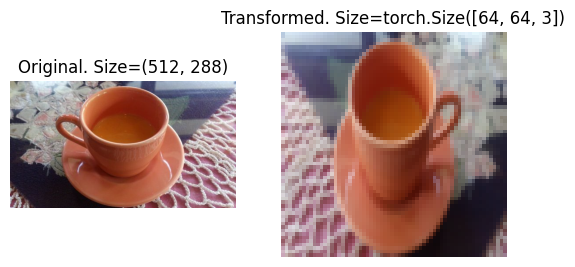

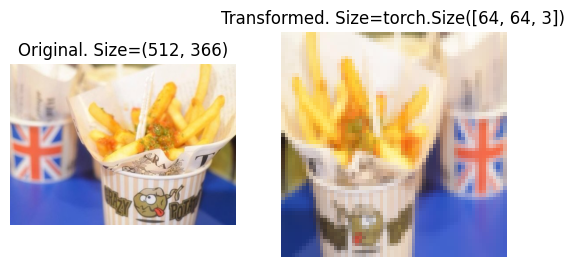

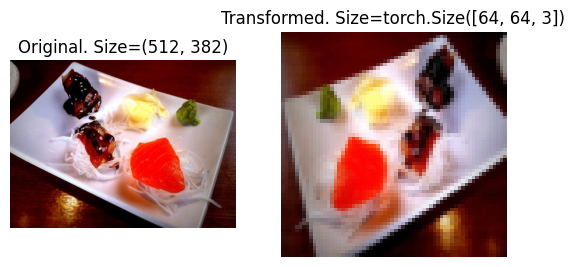

In [9]:
def plot_transforms(image_paths, transform, seed=42):
  random.seed(seed)
  random_img_paths = random.sample(image_paths, k=3)
  for image_path in random_img_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original. Size={f.size}")
      ax[0].axis("off")

      transformed_img = transform(f).permute(1, 2, 0)  # channels last (first by default)
      ax[1].imshow(transformed_img)
      ax[1].set_title(f"Transformed. Size={transformed_img.shape}")
      ax[1].axis("off")

plot_transforms(image_path_list, data_transform)

# **Converting to Dataset**

## Option 1.  ImageFolder

In [10]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

In [11]:
train_data

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [12]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [13]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [14]:
len(train_data), len(test_data)

(225, 75)

as I undersood, permute is a tensor method that swaps axises.<br>
In code below it takes 1st dim (height) and replaces it by the second

torch.Size([64, 64, 3])


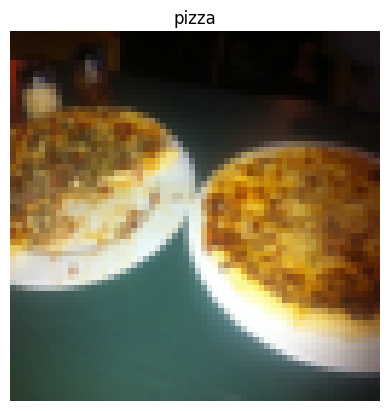

In [15]:
image, label = train_data[0]
plt.title(class_names[label])
plt.axis("off")
print(image.permute(1, 2, 0).size())
plt.imshow(image.permute(1, 2, 0));

In [21]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1,
                              num_workers=2,  # typically set to number of cpus
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=2,  # os.cpu_count() can help
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7df40e4709a0>,
 <torch.utils.data.dataloader.DataLoader at 0x7df40e471540>)

## Option 2. Custom Dataset
Pros:
- more flexibility
Cons:
- more code to write, hence higher error chance

In [31]:
import os
import pathlib

In [23]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [26]:
for dir in os.scandir(train_dir):
  print(dir.name)

pizza
sushi
steak


In [29]:
def classes(path):
  classes = [dir.name for dir in os.scandir(path)]
  class_dict = {class_name: i for i, class_name in enumerate(classes)}

  return classes, class_dict

Oh boi... That's a tasty piece of code!

In [32]:
class ImageFolderKinda(torch.utils.data.Dataset):
  def __init__(self, root_dir, transform=None):
    self.paths = list(pathlib.Path(root_dir).glob("*/*.jpg"))
    self.classes, self.class_dict = classes(root_dir)
    self.transform = transform  # torchvision transformation

  def __len__(self):
    return len(self.paths)

  def load_item(self, index):
    image_path = self.paths[index]
    return Image.open(image_path)

  def __getitem__(self, index):
    # parent in our structure is a folder with classname
    classname = self.paths[index].parent.name
    class_idx = self.class_dict[classname]
    img = self.load_item(index)

    if self.transform:
      img = self.transform(img)
    return img, class_idx

In [33]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [35]:
train_data_custom = ImageFolderKinda(root_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderKinda(root_dir=test_dir,
                                     transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderKinda at 0x7df40ea15660>,
 <__main__.ImageFolderKinda at 0x7df40ea17250>)

In [36]:
len(train_data_custom)

225

In [37]:
train_data_custom.classes

['pizza', 'sushi', 'steak']

In [39]:
img, class_idx = train_data_custom[4]

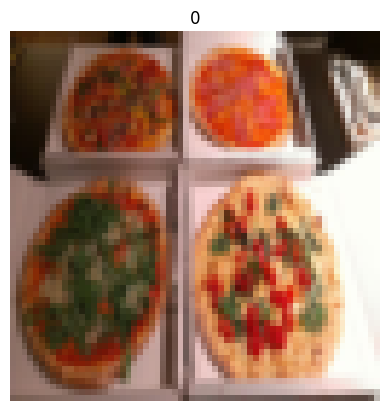

In [42]:
plt.title(class_idx)
plt.axis("off")
plt.imshow(img.permute(1, 2, 0));

Holy shi.. it works!

Let's code a simple function to show random images

In [50]:
def display_k_random_imgs(dataset, k=5, seed=None):
  if seed: random.seed(seed)
  indices = random.sample(range(len(dataset)), k)

  for i, sample in enumerate(indices):
    img, lbl = dataset[sample][0], dataset[sample][1]
    img = img.permute(1, 2, 0)

    plt.subplot(1, k, i+1)
    plt.axis("off")
    plt.title(lbl)
    plt.imshow(img);

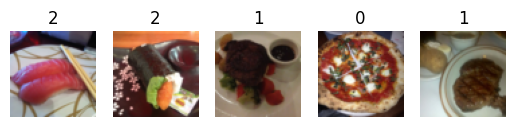

In [52]:
display_k_random_imgs(train_data)

Last, but not least

In [54]:
train_dataloader_kinda = DataLoader(dataset=train_data_custom,
                                    batch_size=1,
                                    num_workers=2,
                                    shuffle=True)

test_dataloader_kinda = DataLoader(dataset=test_data_custom,
                                   batch_size=1,
                                   num_workers=2,
                                   shuffle=False)

train_dataloader_kinda, test_dataloader_kinda

(<torch.utils.data.dataloader.DataLoader at 0x7df40d6c2470>,
 <torch.utils.data.dataloader.DataLoader at 0x7df40d6c3a90>)

Works like a charm converting it to DataLoader (since we inherit torch.utils.data.Dataset)